In [1]:
# general
import datetime as dt

# data handling
import numpy as np
import pandas as pd

# plotting
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# forecasting
import fbprophet as prophet

# from imports
from plotly.tools import FigureFactory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot  # for offline use
from pandas.io import gbq

from typing import Union, Optional

from query import Query  # custom -> export PYTHONPATH=/path/to/query.py

# run plotly offline and initialize notebook plotting
init_notebook_mode(connected=True)

In [33]:
# matplotlib: setup of figure parameters
rcParams = {"axes.labelsize": 15,
            "axes.titlesize": 17,
            "font.size": 15,
            "legend.fontsize": 15,
            "xtick.labelsize": 15,
            "ytick.labelsize": 15,
            "text.usetex": False,
            "figure.figsize": (12, 9)}

# update settings above
mpl.rcParams.update(rcParams)

In [4]:
def read_ts(stationID: Union[int, str], 
            data: Union[list, str], 
            begin: Optional[dt.datetime]=None, 
            end: Optional[dt.datetime]=None,
            query: Union[str, Query, None]=None,
            resample_rule: str="12H") -> tuple:
    """Read timeseries for given data/sensor labels and return in raw/resampled form.
    
    If query is given, use the given query instead of the prebuilt one.
    """
    # sanitizing
    if data:
        data = data if isinstance(data, list) else [data]
    
    if not isinstance(begin, dt.datetime) and not query:
        raise TypeError(f"Expected 'begin' to be datetime.datetime object, but received {type(begin)}.")

    dfs = dict()
    dfs_resampled = dict()

    for sl in data:
        print(f"Working on {sl}-dataset...")
        # create query object
        if not query:
            end = dt.datetime.now(tz=dt.timezone.utc)
            q = Query(SELECT=f"TBTimestamp AS ts, {sl}_Scaled AS {sl}_ts",
                      FROM="`exeter-science-unit.airmonitor.airmonitor`",
                      WHERE=f"UniqueID = {stationID} AND {sl}_Status = 'Valid' AND {sl}_Scaled >= 0" 
                            f" AND TBTimestamp >= '{begin}' AND TBTimestamp <= '{end}'",
                      ORDERBY="ts")
        else:
            q = query

        # read data
        dfs[sl] = gbq.read_gbq(str(q), dialect='standard')

        # transform timestamps to datetime and set index to datetime
        dfs[sl].ts = pd.to_datetime(dfs[sl].ts)
        dfs[sl].index = dfs[sl].ts

        # resample data
        dfs_resampled[sl] = dfs[sl].resample(resample_rule).mean()
        
    return dfs, dfs_resampled


In [5]:
begin = dt.datetime(year=2017, month=6, day=3, tzinfo=dt.timezone.utc)
resample_rule = "12H"
stationID = 131150
texify = {"CO": "$\\mathsf{CO}$",
          "NO": "$\\mathsf{NO}$",
          "NO2": "$\\mathsf{NO}_2$",
          "O3": "$\\mathsf{O}_3$"}

In [6]:
dfs, dfs_resampled = read_ts(stationID=stationID, data=sorted(list(texify.keys())),
                             begin=begin)

Working on CO-dataset...


INFO:pandas_gbq.gbq:Query running...
INFO:pandas_gbq.gbq:Total time taken 31.81 s.
Finished at 2018-10-16 15:02:41.


Working on NO-dataset...


INFO:pandas_gbq.gbq:Query running...
INFO:pandas_gbq.gbq:Total time taken 28.73 s.
Finished at 2018-10-16 15:03:11.


Working on NO2-dataset...


INFO:pandas_gbq.gbq:Query running...
INFO:pandas_gbq.gbq:Total time taken 31.07 s.
Finished at 2018-10-16 15:03:43.


Working on O3-dataset...


INFO:pandas_gbq.gbq:Query running...
INFO:pandas_gbq.gbq:Total time taken 32.18 s.
Finished at 2018-10-16 15:04:16.


In [7]:
T_query = Query(SELECT=f"TBTimestamp AS ts, TEMP_Scaled AS TEMP_ts",
                      FROM="`exeter-science-unit.airmonitor.airmonitor`",
                      WHERE=f"UniqueID = {stationID} AND TEMP_Status = 'Valid'" 
                            f" AND TBTimestamp >= '{begin}' AND TBTimestamp <= '{dt.datetime.now(tz=dt.timezone.utc)}'",
                      ORDERBY="ts")

T_df, T_df_resampled = read_ts(stationID=stationID, data="TEMP", query=T_query)

Working on TEMP-dataset...


INFO:pandas_gbq.gbq:Query running...
INFO:pandas_gbq.gbq:Total time taken 29.15 s.
Finished at 2018-10-16 15:04:47.


## Plotting with Pandas 

Text(0.5, 1.0, 'Station 131150')

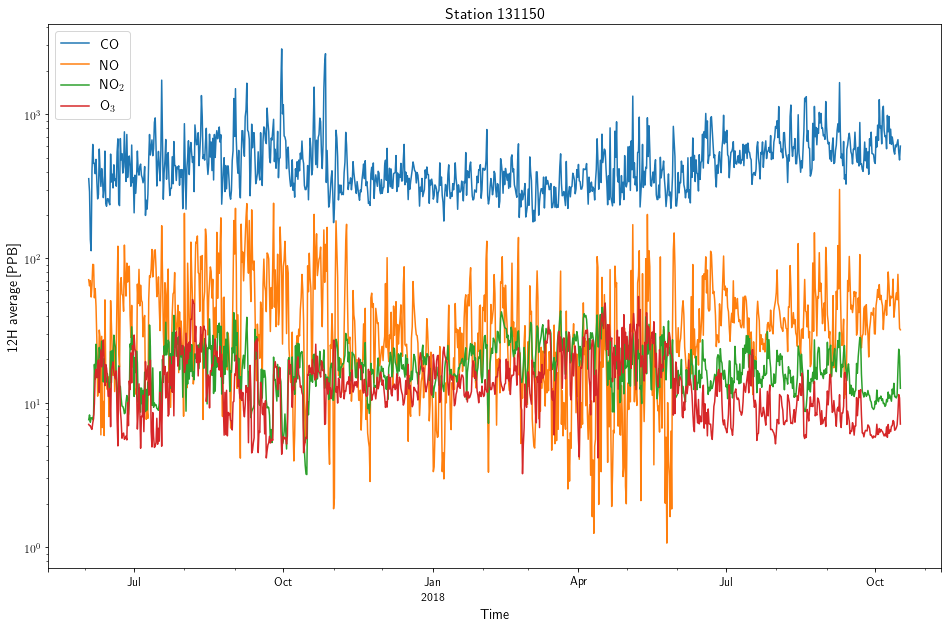

In [8]:
# figure setup
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)

# adding lines to the axis
for sl, df in sorted(dfs_resampled.items()):
    df.plot(style='-', ms=5, fontsize=12, ax=ax)

# legend and scale(s)    
ax.legend([texify[key] for key in sorted(list(dfs_resampled.keys()))], fontsize=14)
ax.set_yscale('log')

# cosmetics
ax.set_ylabel(f"{resample_rule} average [PPB]", fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_title(f"Station {stationID}", fontsize=16)


## Plotting with Plotly

In [9]:
data = []
for sl, df in sorted(dfs_resampled.items()):
    data.append(go.Scatter(x=df.index, 
                           y=getattr(df, f"{sl}_ts"),  # get data attribute of DataFrame
                           name=sl))  # latex doesn't work right now for plotly for some reason... 

# setting layout options
layout = go.Layout(showlegend=True, title=f"Station {stationID}", width=900, height=700)

# creating figure object
fig = go.Figure(data=data, layout=layout)

# cosmetics
fig.layout.yaxis.update({'title': f"{resample_rule} average [PPB]", 'type': "log"})
fig.layout.xaxis.update({'title': f"Time [steps of {resample_rule}]"})

# actual plotting
iplot(fig)

# Forecasting
a humble approach using Facebook's Prophet package

## Temperature

In [10]:
# set the size of training data
lim = 950

# Prophet requires columns ds (Date) and y (value) 
train_T = T_df_resampled['TEMP'][:lim]  # set training set
test_T = T_df_resampled['TEMP'][lim:]  # set testing set
train_T = train_T.rename(columns={'TEMP_ts': 'y'})  # rename column to 'y'
train_T['ds'] = train_T.index  # rename column to 'ds'

# Make the prophet model and fit on the data using default values, but enforcing yearly seasonality
T_prophet = prophet.Prophet(yearly_seasonality=True)
T_prophet.fit(train_T)

In [ ]:
# Make a future dataframe in steps of 12H
T_forecast = T_prophet.make_future_dataframe(periods=200, freq='12H')

# Make predictions
T_forecast = T_prophet.predict(T_forecast)  # also contains historical data

### Plotting with Pandas

Text(0.5, 55.0, 'Time')

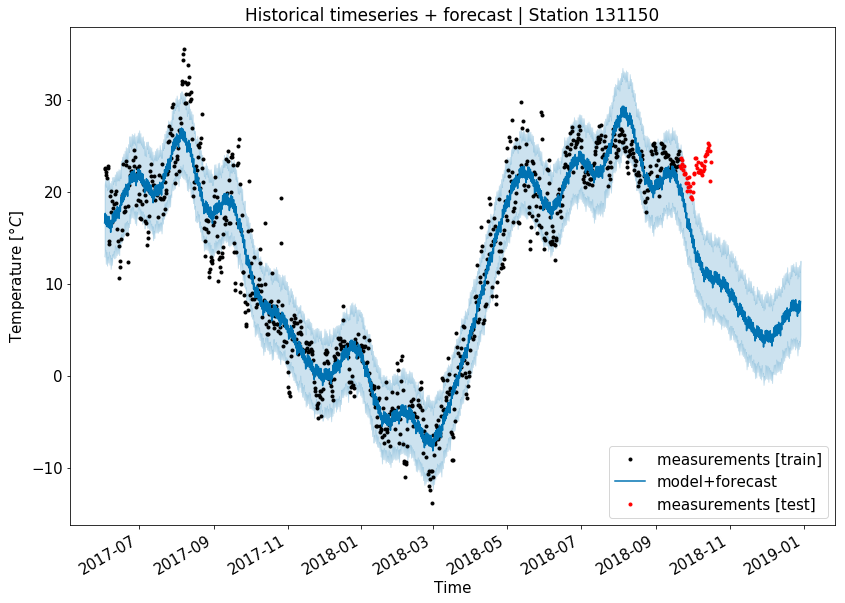

In [39]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

T_prophet.plot(T_forecast, ax=ax, xlabel="Time", ylabel="Temperature $[\\degree C]$")
test_T.plot(style='ro', ms=3, ax=ax)
leg = ax.legend(['measurements [train]', 'model+forecast', 'measurements [test]'], loc=4)
ax.set_title(f"Historical timeseries + forecast | Station {stationID}")
ax.set_xlabel("Time")  # because somehow the optional argument of prophet.Prophet.plot doesn't work

### Plotting with Plotly
since we already have the DataFrame it's gonna make things easier.. 

In [54]:
train_trace = go.Scatter(x=train_T.index, 
                         y=train_T.y,  # get data attribute of DataFrame
                         mode="markers",  # setting markers instead of lines
                         marker={'size': 5,
                                 'color': 'rgb(0, 0, 0)'},  # black
                         name="[train]")  # latex doesn't work right now for plotly for some reason... 
test_trace = go.Scatter(x=test_T.index,
                        y=test_T.TEMP_ts,
                        mode="markers",
                        marker={'size': 5,
                                'color': '#d62768'},
                        name="[test]")

forecast_upper_trace = go.Scatter(x=T_forecast.ds,
                                  y=T_forecast.yhat_upper,
                                  marker={'color': "#444"},
                                  line={'width': 0},
                                  showlegend=False,
                                  name="Upper bound")


forecast_lower_trace = go.Scatter(x=T_forecast.ds,
                                  y=T_forecast.yhat_lower,
                                  fill="tonexty",
                                  marker={'color': "#444"},
                                  line={'width': 0},
                                  fillcolor="rgba(68, 68, 68, 0.3)",
                                  showlegend=False,
                                  name="Lower bound")

forecast_trace = go.Scatter(x=T_forecast.ds,
                            y=T_forecast.yhat,
                            name="Model+Forecast",
                            marker={"color": "rgb(31, 119, 180)"})

# order of traces is very important because lower_trace has option "fill to next y": it must follow upper trace
data = [train_trace, test_trace, forecast_upper_trace, forecast_lower_trace, forecast_trace]

# setting layout options
layout = go.Layout(showlegend=True, title=f"Historical timeseries + forecast | Station {stationID}", 
                   width=900, height=700)

# creating figure object
fig = go.Figure(data=data, layout=layout)

# cosmetics
fig.layout.yaxis.update({'title': f"{resample_rule}-average Temperature [°C]"})
fig.layout.xaxis.update({'title': f"Time [steps of {resample_rule}]"})

# actual plotting
iplot(fig)

## Gases
use $\mathsf{CO}$ as an example

In [60]:
# set the size of training data
lim = 950

# Prophet requires columns ds (Date) and y (value) 
train_df = dfs_resampled['CO'][:lim]  # set training set
test_df = dfs_resampled['CO'][lim:]  # set testing set
train_df = train_df.rename(columns={'CO_ts': 'y'})  # rename column to 'y'
train_df['ds'] = train_df.index  # rename column to 'ds'

# Make the prophet model and fit on the data using default values, but enforcing yearly seasonality
CO_prophet = prophet.Prophet(changepoint_prior_scale=0.15, yearly_seasonality=True)
CO_prophet.fit(train_df)

# Make a future dataframe in steps of 12H
CO_forecast = CO_prophet.make_future_dataframe(periods=200, freq='12H')

# Make predictions
CO_forecast = CO_prophet.predict(CO_forecast)  # also contains historical data

### Plotting with Pandas again

Text(0.5, 55.0, 'Time')

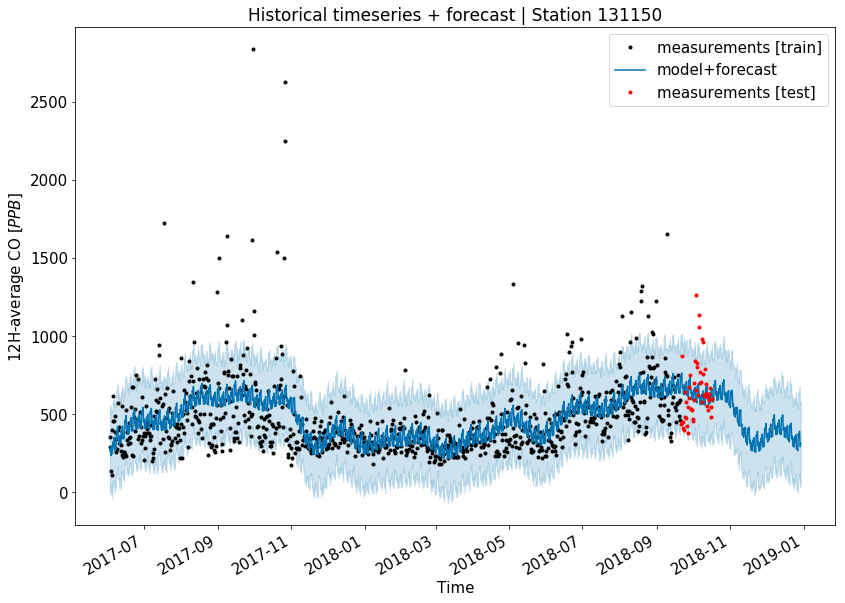

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)

CO_prophet.plot(CO_forecast, ax=ax, xlabel="Time", ylabel=f"{resample_rule}-average CO $[PPB]$")
test_df.plot(style='ro', ms=3, ax=ax)
leg = ax.legend(['measurements [train]', 'model+forecast', 'measurements [test]'], loc=0)
ax.set_title(f"Historical timeseries + forecast | Station {stationID}")
ax.set_xlabel("Time")  # because somehow the optional argument of prophet.Prophet.plot doesn't work

### Plotting with Plotly again

In [63]:
train_trace = go.Scatter(x=train_df.index, 
                         y=train_df.y,  # get data attribute of DataFrame
                         mode="markers",  # setting markers instead of lines
                         marker={'size': 5,
                                 'color': 'rgb(0, 0, 0)'},  # black
                         name="[train]")  # latex doesn't work right now for plotly for some reason... 
test_trace = go.Scatter(x=test_df.index,
                        y=test_df.CO_ts,
                        mode="markers",
                        marker={'size': 5,
                                'color': '#d62768'},
                        name="[test]")

forecast_upper_trace = go.Scatter(x=CO_forecast.ds,
                                  y=CO_forecast.yhat_upper,
                                  marker={'color': "#444"},
                                  line={'width': 0},
                                  showlegend=False,
                                  name="Upper bound")


forecast_lower_trace = go.Scatter(x=CO_forecast.ds,
                                  y=CO_forecast.yhat_lower,
                                  fill="tonexty",
                                  marker={'color': "#444"},
                                  line={'width': 0},
                                  fillcolor="rgba(68, 68, 68, 0.3)",
                                  showlegend=False,
                                  name="Lower bound")

forecast_trace = go.Scatter(x=CO_forecast.ds,
                            y=CO_forecast.yhat,
                            name="Model+Forecast",
                            marker={"color": "rgb(31, 119, 180)"})

# order of traces is very important because lower_trace has option "fill to next y": it must follow upper trace
data = [train_trace, test_trace, forecast_upper_trace, forecast_lower_trace, forecast_trace]

# setting layout options
layout = go.Layout(showlegend=True, title=f"Historical timeseries + forecast | Station {stationID}", 
                   width=900, height=700)

# creating figure object
fig = go.Figure(data=data, layout=layout)

# cosmetics
fig.layout.yaxis.update({'title': f"{resample_rule}-average CO [PPB]"})
fig.layout.xaxis.update({'title': f"Time [steps of {resample_rule}]"})

# actual plotting
iplot(fig)